In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from py12box_invert.invert import Invert
from py12box_laube import get_data
from py12box_agage.utils import get_inversion_params
import pandas as pd

In [47]:
species_list = ["H-1202"]
network = "laube"

for species in species_list:
    
    
    # Work out paths
    project_path = get_data(f"{species}")
    
    if network == "agage":
        parts = list(project_path.parts)
        parts[-2] = parts[-2] + "_agage"
        project_path = Path(*parts)
        network_in = network
    else:
        network_in = network
    
    obs_path = project_path / f"inputs/{species}_obs_{network_in}.csv"
    output_path = project_path / f"outputs/{species}_out.p"

    if not output_path.parent.exists():
        output_path.parent.mkdir()

    # Get inversion parameters
    inversion_params = get_inversion_params(species)

    # Set up inversion
    inv = Invert(project_path / "inputs", species,
                obs_path = obs_path,
                method="iterative_rigby14",
                n_threads=1,
                sensitivity_freq=inversion_params.loc["Sensitivity frequency"],
                end_year=2024.)


    # Calculate emissions uncertainty
    emissions_box = inv.mod.emissions.mean(axis=0)

    invert_uncertainty = inv.mod.emissions.sum(axis=1).max() * inversion_params.loc["Growth uncertainty (%)"]/100.
    invert_uncertainty_box = np.sqrt(invert_uncertainty**2 * emissions_box / emissions_box.sum())
    invert_uncertainty_min = invert_uncertainty*0.01
    
    invert_uncertainty_box[invert_uncertainty_box < invert_uncertainty_min] = invert_uncertainty_min.copy()

    # Run inversion
    inv.run_inversion(invert_uncertainty_box,
                    lifetime_error=inversion_params.loc["Overall lifetime uncertainty (%)"]/100.,
                    scale_error=np.mean([inversion_params.loc["Scale error plus (%)"]/100.,
                        inversion_params.loc["Scale error minus (%)"]/100.]))

    # Save outputs
    inv.save(output_path)

    # Write to csv
    inv.to_csv(project_path / "outputs/")


Setting up inversion for H-1202

No units given for emissions. Assuming Gg/yr
No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 4 iterations
... stratospheric lifetime: 36.1
... OH lifetime: 120.3
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 2.8
... overall lifetime: 2.5
... done in 0.0008 s
Calculating flux sensitivity on 1 threads...
... done
Spinning up for 9 years and estimating initial conditions...
... done
Run inversion...
... done
Calculating outputs...
... calculating posterior ensembles


/user/work/lw13938/py12box_invert/py12box_invert/inversion_modules.py:102: RuntimeWarning: invalid value encountered in true_divide
  burden_scaled = np.vstack([global_burden * np.abs(emissions[:, bi])/global_emissions for bi in range(4)]).T


... done



In [20]:
#H-1211
htoc1211_index = np.arange(1975, 2019)+0.46
htoc1211 = np.array([2184, 2609, 3079, 3628, 4195, 4363, 4005 ,4648, 5276, 6273, 7441, 8618, 10277, 12196, 12972 ,13137 ,12004, 10477,
                     10339, 10877, 11166, 11239, 11731 ,11429, 10486, 9774, 9000, 8233, 7564, 6639, 5602, 3046, 2825, 2651, 2479, 2324,
                     2179, 2043, 2228, 2059, 1905, 1769, 1640, 1523])*1e-3

(1980.0, 2028.06)

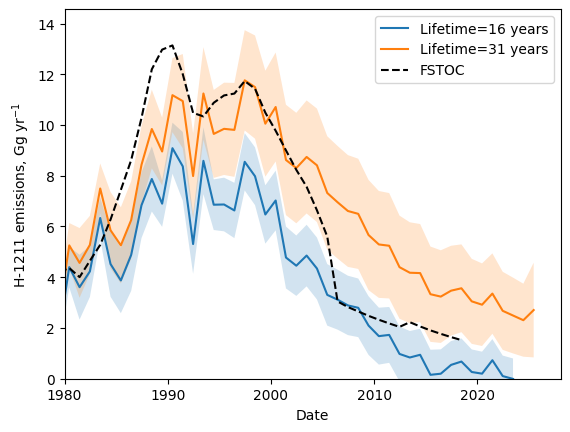

In [ ]:
species = "H-1202"

py_path = Path(f"/user/home/lw13938/work/py12box_laube/data_agage/{species}/outputs/{species}_Global_annual_emissions.csv")
if py_path.exists():
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = em_csv['Decimal_date'].values
    data = em_csv['Global_annual_emissions'].values
    data_sd = em_csv['Global_annual_emissions_1-sigma'].values

py_path = Path(f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_emissions.csv")
if py_path.exists():
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    indexa= em_csv['Decimal_date'].values
    dataa = em_csv['Global_annual_emissions'].values
    data_sda = em_csv['Global_annual_emissions_1-sigma'].values
    
plt.figure()
plt.plot(index, data, label="Lifetime=16 years")
plt.fill_between(index, data+data_sd, data-data_sd, alpha=0.2)
plt.plot(indexa, dataa, label="Lifetime=31 years")
plt.fill_between(indexa, dataa+data_sda, dataa-data_sda, alpha=0.2)
plt.plot(htoc1211_index, htoc1211, 'k--', label="FSTOC")
plt.ylabel(species+" emissions, Gg yr$^{-1}$")
plt.xlabel("Date")
plt.ylim(0,None)
plt.legend()
plt.xlim(1980, None)

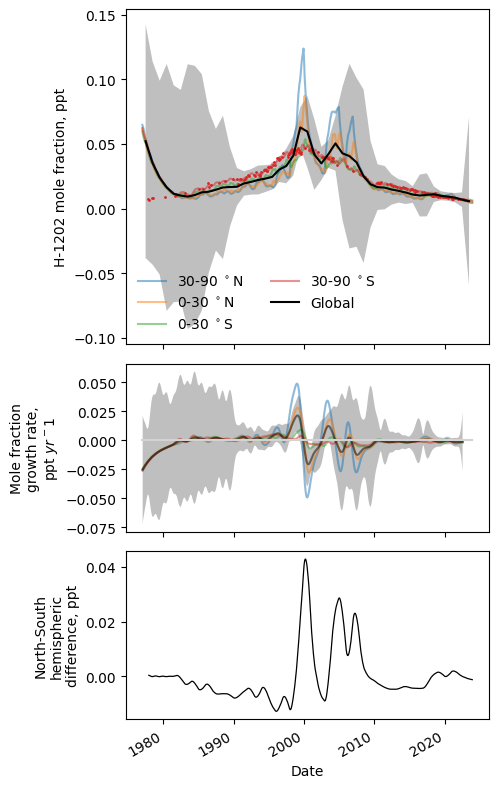

In [48]:
labels = ["30-90 $^\circ$N", "0-30 $^\circ$N", "0-30 $^\circ$S", "30-90 $^\circ$S"]

for species in species_list:
    #
    path = f"/user/home/lw13938/work/py12box_{network}/data/{species}/outputs/"
    if Path(path+f"{species}_Semihemispheric_modelled_mole_fractions.csv").exists():
        agagemf_file = pd.read_csv(path+f"{species}_Semihemispheric_modelled_mole_fractions.csv",
                                comment="#",index_col=False)
        agagegmf_file = pd.read_csv(path+f"{species}_Global_annual_mole_fraction.csv",
                                comment="#",index_col=False)
        agagegr_file = pd.read_csv(path+f"{species}_Semihemispheric_mole_fraction_growth_rate.csv",
                                comment="#",index_col=False)
        agageggr_file = pd.read_csv(path+f"{species}_Global_mole_fraction_growth_rate.csv",
                                comment="#",index_col=False)
        agageobsmf_file = pd.read_csv(path+f"{species}_Semihemispheric_mole_fractions.csv",
                                comment="#",index_col=False)
        date = agagemf_file["Decimal_date"].values
    else:
        continue
    
    fig, axes_all = plt.subplots(3, 1, figsize=(5,8.), sharex='all',gridspec_kw={'height_ratios': [2, 1, 1]})
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0.1)
    axes = axes_all.flatten()

    ax = axes[0]
    ax1 = axes[1]
    ax2 = axes[2]


    for i in range(4):
        p = ax.plot(date, agagemf_file['Semihemispheric_modelled_mole_fractions_box'+str(i)], alpha=0.5, label=labels[i])
        ax1.plot(agagegr_file["Decimal_date"].values, agagegr_file['Semihemispheric_mole_fraction_growth_rate_box'+str(i)], alpha=0.5)
        c = p[0].get_color()
        ax.plot(agageobsmf_file["Decimal_date"], agageobsmf_file['Semihemispheric_mole_fractions_box'+str(i)], "o", color=c, markersize=1)    
    ax.plot(agagegmf_file["Decimal_date"].values, agagegmf_file["Global_annual_mole_fraction"], "k", label="Global")
    ax.fill_between(agagegmf_file["Decimal_date"].values, 
                        agagegmf_file["Global_annual_mole_fraction"]+agagegmf_file["Global_annual_mole_fraction_1-sigma"], 
                        agagegmf_file["Global_annual_mole_fraction"]-agagegmf_file["Global_annual_mole_fraction_1-sigma"],
                        facecolor="k", alpha=0.25)
    for axi1 in [ax1]:
        axi1.plot(agageggr_file["Decimal_date"].values, agageggr_file['Global_mole_fraction_growth_rate'], "k", alpha=0.5)
        axi1.fill_between(agageggr_file["Decimal_date"].values, 
                        agageggr_file['Global_mole_fraction_growth_rate']+agageggr_file['Global_mole_fraction_growth_rate_1-sigma'],
                        agageggr_file['Global_mole_fraction_growth_rate']-agageggr_file['Global_mole_fraction_growth_rate_1-sigma'],
                        facecolor="black", alpha=0.25)
    ax1.plot(agageobsmf_file["Decimal_date"].values, np.zeros_like(agageobsmf_file["Decimal_date"].values),color="lightgrey")
    ihd = (agagemf_file['Semihemispheric_modelled_mole_fractions_box0']+agagemf_file['Semihemispheric_modelled_mole_fractions_box1'])/2 - \
        (agagemf_file['Semihemispheric_modelled_mole_fractions_box2']+agagemf_file['Semihemispheric_modelled_mole_fractions_box3'])/2
    serihd = pd.Series(data = ihd.values, index = date).rolling(12).mean()

    ax2.plot(serihd.index, serihd.values, "k", linewidth=0.9)

    if species == "CH4" or species == "N2O":
        units = "ppb"
    else:
        units = "ppt"
    ax.set_ylabel(f"{species} mole fraction, {units}")
    ax1.set_ylabel(f"Mole fraction\ngrowth rate,\n{units} $yr^{-1}$")
    ax2.set_ylabel(f"North-South\nhemispheric\ndifference, {units}")#, labelpad=22)
    ax2.set_xlabel("Date")

    # ax.set_title(network)

    fig.autofmt_xdate()
    

    ax.legend(frameon=False, ncol=2) #loc="lower left", 
    
    plt.tight_layout()

(0.0, 1.11)

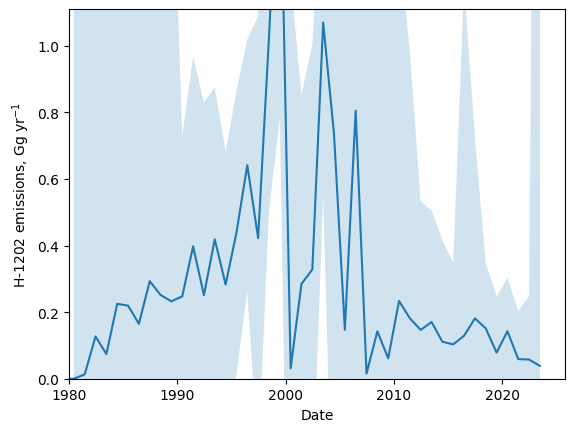

In [49]:
species = "H-1202"

py_path = Path(f"/user/home/lw13938/work/py12box_laube/data/{species}/outputs/{species}_Global_annual_emissions.csv")
if py_path.exists():
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = em_csv['Decimal_date'].values
    data = em_csv['Global_annual_emissions'].values
    data_sd = em_csv['Global_annual_emissions_1-sigma'].values

plt.figure()
plt.plot(index, data)
plt.fill_between(index, data+data_sd, data-data_sd, alpha=0.2)
plt.ylabel(species+" emissions, Gg yr$^{-1}$")
plt.xlabel("Date")
plt.xlim(1980, None)
plt.ylim(0, 1.11)